In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(".."))
from datasets import get_transform, get_dataloaders
from utils import get_model

In [25]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model_path = "..\model_ckpt\lenet_mnist_model.pth"
data_dir = "..\data"
torch.manual_seed(42)

In [26]:
from models.lenet import LeNet


_,_,test_loader = get_dataloaders('mnist',data_dir, batch_size=1)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = LeNet().to(device)

model.load_state_dict(torch.load(pretrained_model_path, map_location=device, weights_only=True))


model.eval()

Using cuda device


LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
def fgsm_attack(origin_image,epsilon,data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = origin_image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image,0,1)
    return perturbed_image

def denorm(batch_img,mean=[0.1307],std=[0.3081]):
    # batch_img shape:(B,C,H,W)
    if isinstance(mean,list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std,list):
        std = torch.tensor(std).to(device)
    # adjust shape ro[1,C,1,1],-1 means auto adjust dim size
    return batch_img * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

from tqdm import tqdm

def attack(model,device,test_loader,epsilon):
    correct = 0
    adv_examples = []

    for idx,(data,target) in enumerate(tqdm(test_loader,desc="Attacking")):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = torch.max(output,1,keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output,target)
        model.zero_grad()

        loss.backward()
        data_grad = data.grad.data

        data_denorm = denorm(data)

        perturbed_data = fgsm_attack(data_denorm,epsilon,data_grad)

        normalize = transforms.Normalize((0.1307,), (0.3081,))
        perturbed_data_norm = normalize(perturbed_data)

        output = model(perturbed_data_norm)
        final_pred = torch.max(output,1,keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct}/{len(test_loader)} = {final_acc:.4f}")

    return final_acc, adv_examples
        

In [28]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 318.96it/s]


Epsilon: 0	Test Accuracy = 9912/10000 = 0.9912


Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 322.30it/s]


Epsilon: 0.05	Test Accuracy = 9605/10000 = 0.9605


Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 319.32it/s]


Epsilon: 0.1	Test Accuracy = 8743/10000 = 0.8743


Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 319.93it/s]


Epsilon: 0.15	Test Accuracy = 7108/10000 = 0.7108


Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 315.67it/s]


Epsilon: 0.2	Test Accuracy = 4874/10000 = 0.4874


Attacking: 100%|██████████| 10000/10000 [00:30<00:00, 325.01it/s]


Epsilon: 0.25	Test Accuracy = 2710/10000 = 0.2710


Attacking: 100%|██████████| 10000/10000 [00:31<00:00, 315.63it/s]

Epsilon: 0.3	Test Accuracy = 1420/10000 = 0.1420


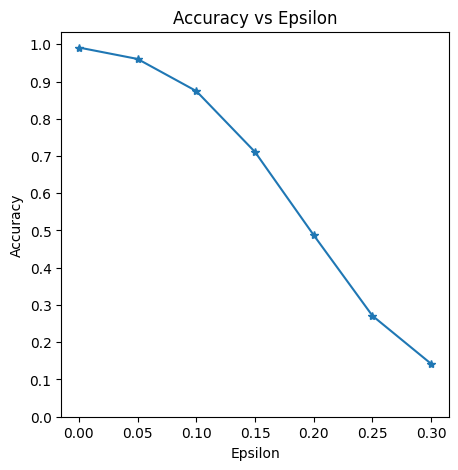

In [29]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()